In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import string
import joblib
import re
# from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
# load_dotenv('../.env')
os.environ['MLFLOW_TRACKING_USERNAME'] = 'sinanshamsudheen'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'cd101ef722400d4771c17b6f8a661487a22abd3b'

In [3]:
df = pd.read_csv('spam_Emails_data.csv')
df.head()

,label,text
0,Spam,viiiiiiagraaaa\nonly for the ones that want to...
1,Ham,got ice thought look az original message ice o...
2,Spam,yo ur wom an ne eds an escapenumber in ch ma n...
3,Spam,start increasing your odds of success & live s...
4,Ham,author jra date escapenumber escapenumber esca...


In [4]:
df['label'] = df['label'].apply(lambda x: 1 if x=='Spam' else 0)

In [5]:
df['label'].unique()

array([1, 0], dtype=int64)

In [6]:
df = df.dropna()

In [7]:
df.isnull().sum()

label    0
text     0
dtype: int64

In [8]:
def clean_text(text):
    text = str(text).lower()                               # Lowercase
    text = re.sub(r'\n', ' ', text)                        # Remove newlines
    text = re.sub(r'http\S+|www.\S+', '', text)            # Remove URLs
    text = re.sub(r'<.*?>', '', text)                      # Remove HTML tags
    text = re.sub(r'\d+', '', text)                        # Remove numbers
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()               # Remove extra whitespace
    return text

In [9]:
df['text'] = df['text'].apply(clean_text)

In [10]:
manual_stopwords = set("""
a about above after again against all am an and any are aren't as at be because been before being below between 
both but by can't cannot could couldn't did didn't do does doesn't doing don't down during each few for from further 
had hadn't has hasn't have haven't having he he'd he'll he's her here here's hers herself him himself his how how's i 
i'd i'll i'm i've if in into is isn't it it's its itself let's me more most mustn't my myself no nor not of off on 
once only or other ought our ours ourselves out over own same shan't she she'd she'll she's should shouldn't so some 
such than that that's the their theirs them themselves then there there's these they they'd they'll they're they've 
this those through to too under until up very was wasn't we we'd we'll we're we've were weren't what what's when when's 
where where's which while who who's whom why why's with won't would wouldn't you you'd you'll you're you've your yours 
yourself yourselves
""".split())

In [11]:
def extract_features(text):
    words = text.lower().split()
    total_words = len(words)
    stopword_count = sum(1 for word in words if word in manual_stopwords)
    
    return pd.Series({
        'text_length': len(text),
        'word_count': total_words,
        'sentence_count': text.count('.') + text.count('!') + text.count('?'),
        'punctuation_count': sum([1 for char in text if char in '.,!?;:']),
        'uppercase_ratio': sum(1 for c in text if c.isupper()) / len(text) if len(text) > 0 else 0,
        'unique_word_count': len(set(words)),
        'stopword_ratio': stopword_count / total_words if total_words > 0 else 0,
        'avg_word_len': np.mean([len(word) for word in words]) if words else 0,
    })


In [12]:
extra_features_df = df['text'].apply(extract_features)

In [13]:
df.dtypes

label     int64
text     object
dtype: object

In [14]:
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(df['text'])

In [15]:
X_text.shape, extra_features_df.shape

((193850, 5000), (193850, 8))

In [16]:
from sklearn.preprocessing import StandardScaler

# Scale only the extra features
scaler = StandardScaler()
extra_features_scaled = scaler.fit_transform(extra_features_df)

In [17]:
X_all = np.hstack([X_text.toarray(), extra_features_scaled])
y = df['label']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, stratify=y, random_state=42)


In [19]:
import numpy as np
print("Unique labels in y:", np.unique(y))
print("Unique labels in y_train:", np.unique(y_train))


Unique labels in y: [0 1]
Unique labels in y_train: [0 1]


In [20]:
model = LogisticRegression(class_weight='balanced', max_iter=3000)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=3000)

In [21]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     20432
           1       0.96      0.98      0.97     18338

    accuracy                           0.97     38770
   macro avg       0.97      0.97      0.97     38770
weighted avg       0.97      0.97      0.97     38770



In [22]:
# from sklearn.model_selection import GridSearchCV

# params = {
#     'C': [0.1, 1, 10],
#     'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 1.5}, 'balanced'],
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear', 'saga'],           
#     'max_iter': [1000, 2000, 3000] 
# }
# grid = GridSearchCV(LogisticRegression(max_iter=3000), params, scoring='recall', cv=5)
# grid.fit(X_train, y_train)

# print(grid.best_params_)

In [23]:
# from sklearn.metrics import classification_report

# y_probs = model.predict_proba(X_test)[:, 1]  # Get probability for class 1
# threshold = 0.3  # Try 0.4, 0.35, etc.
# y_pred_thresh = (y_probs >= threshold).astype(int)

# print(classification_report(y_test, y_pred_thresh))


Text(95.72222222222221, 0.5, 'Truth')

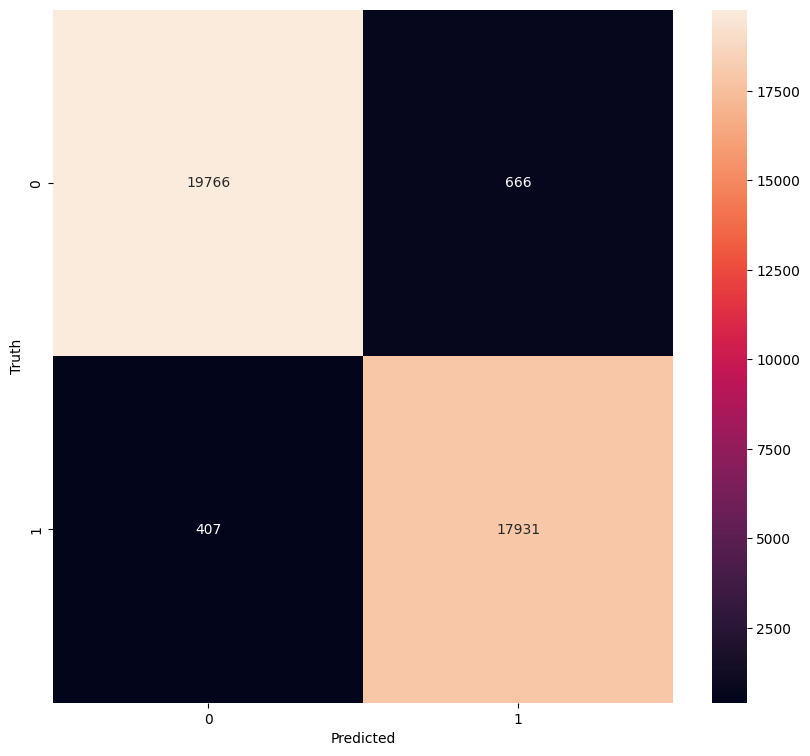

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
labels=[ 0, 1]

plt.figure(figsize=(10,9))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [25]:
df3=pd.DataFrame(X_text)
df3

,0
0,<Compressed Sparse Row sparse matrix of dtype ...
1,<Compressed Sparse Row sparse matrix of dtype ...
2,<Compressed Sparse Row sparse matrix of dtype ...
3,<Compressed Sparse Row sparse matrix of dtype ...
4,<Compressed Sparse Row sparse matrix of dtype ...
...,...
193845,<Compressed Sparse Row sparse matrix of dtype ...
193846,<Compressed Sparse Row sparse matrix of dtype ...
193847,<Compressed Sparse Row sparse matrix of dtype ...
193848,<Compressed Sparse Row sparse matrix of dtype ...


In [26]:
# In your training notebook, after train/test split:
background_sample_size = min(100, len(X_train))
background_indices = np.random.choice(len(X_train), background_sample_size, replace=False)
background_data = X_train[background_indices]
np.save('shap_background_data.npy', background_data)

In [27]:
joblib.dump(model, 'spam_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(extra_features_df.columns.tolist(), 'extra_feature_names.pkl')

['extra_feature_names.pkl']

In [28]:
# Save the scaler for use in prediction
joblib.dump(scaler, 'extra_features_scaler.pkl')
print("Scaler saved successfully!")

Scaler saved successfully!


In [29]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report

# # Logistic Regression model
# lr = LogisticRegression()

# # Define hyperparameter grid
# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100],                # Regularization strength
#     'penalty': ['l1', 'l2'],                     # Regularization type
#     'solver': ['liblinear', 'saga'],             # Solvers compatible with l1 and l2
#     'max_iter': [1000, 2000, 3000]                  # Max iterations
# }

# # GridSearchCV setup
# grid_search = GridSearchCV(
#     estimator=lr,
#     param_grid=param_grid,
#     cv=5,
#     scoring='f1',     # or 'accuracy', 'roc_auc', etc.
#     verbose=2,
#     n_jobs=-1
# )

# # Train on training set
# grid_search.fit(X_train, y_train)

# # Output best parameters and best score
# print("✅ Best Parameters:", grid_search.best_params_)
# print("🏆 Best F1 Score (CV):", grid_search.best_score_)

# # Predict on test set
# y_pred = grid_search.predict(X_test)

# # Evaluate performance
# print("\n📊 Classification Report on Test Set:\n")
# print(classification_report(y_test, y_pred))


In [30]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [31]:
models = [
    (
        "Logistic Regression", 
        {"class_weight":'balanced', 'max_iter':3000},
        LogisticRegression(), 
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "Random Forest", 
        {"n_estimators": 30, "max_depth": 3},
        RandomForestClassifier(), 
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "XGBClassifier",
        {"use_label_encoder": False, "eval_metric": 'logloss'},
        XGBClassifier(), 
        (X_train, y_train),
        (X_test, y_test)
    ),
]

In [32]:
reports = []

for model_name, params, model, train_set, test_set in models:
    X_train = train_set[0]
    y_train = train_set[1]
    X_test = test_set[0]
    y_test = test_set[1]
    
    model.set_params(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)

In [33]:
# MLflow Integration Setup - Import required libraries
import mlflow
import mlflow.sklearn
import mlflow.xgboost  # For XGBoost models
import pickle
import tempfile

In [36]:
# MLFLOW IMPLEMENTATION FOR DAGSHUB
# This implementation is confirmed to work with DagsHub

# Configure MLflow tracking
os.environ['MLFLOW_TRACKING_USERNAME'] = 'sinanshamsudheen'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'cd101ef722400d4771c17b6f8a661487a22abd3b'
os.environ['MLFLOW_TRACKING_URI'] = 'https://dagshub.com/sinanshamsudheen/TLflow.mlflow'
mlflow.set_tracking_uri(os.environ['MLFLOW_TRACKING_URI'])

# Set experiment name
experiment_name = "Email Spam Detection"
mlflow.set_experiment(experiment_name)

# Function to log model safely with DagsHub
def log_model_to_dagshub(model, model_name, params, metrics, description=None):
    """
    Log a model to DagsHub using only the compatible approaches
    
    Parameters:
    - model: The trained model object
    - model_name: Name for the model run
    - params: Dictionary of parameters to log
    - metrics: Dictionary of metrics to log
    - description: Optional description of the model
    """
    # Create a temporary file for the model
    with tempfile.NamedTemporaryFile(suffix='.pkl', delete=False) as tmp:
        temp_model_path = tmp.name
        pickle.dump(model, tmp)
    
    try:
        with mlflow.start_run(run_name=model_name):
            # Log description as a tag if provided
            if description:
                mlflow.set_tag("description", description)
            
            # Log model type
            mlflow.set_tag("model_type", type(model).__name__)
            
            # Log parameters
            for key, value in params.items():
                mlflow.log_param(key, str(value))
            
            # Log metrics
            mlflow.log_metrics(metrics)
            
            # Log the model as a simple artifact
            mlflow.log_artifact(temp_model_path, f"{model_name}")
            
            print(f"✅ Successfully logged {model_name} to DagsHub")
            
    except Exception as e:
        print(f"⚠️ Error logging {model_name}: {str(e)}")
        
    finally:
        # Clean up temp file
        if os.path.exists(temp_model_path):
            os.unlink(temp_model_path)

# Code to log all your trained models
def log_all_models():
    try:
        print("Logging models to DagsHub...")
        for i, element in enumerate(models):
            model_name = element[0]
            params = element[1]
            model = element[2]
            report = reports[i]
            
            # Extract metrics from the classification report
            metrics = {
                'accuracy': report['accuracy'],
                'precision_class_1': report['1']['precision'],
                'precision_class_0': report['0']['precision'],
                'recall_class_1': report['1']['recall'],
                'recall_class_0': report['0']['recall'],
                'f1_score_macro': report['macro avg']['f1-score']
            }
            
            # Add description for each model
            if "Logistic Regression" in model_name:
                description = "Logistic Regression model for email spam detection"
            elif "Random Forest" in model_name:
                description = "Random Forest model for email spam detection"
            elif "XGB" in model_name:
                description = "XGBoost model for email spam detection"
            else:
                description = "Model for email spam detection"
                
            # Log the model
            log_model_to_dagshub(model, model_name, params, metrics, description)
            
        print("\n🎉 All models successfully logged to DagsHub!")
        print("🔗 View your experiment at: https://dagshub.com/sinanshamsudheen/TLflow.mlflow/#/experiments")
        
    except NameError as e:
        print(f"\n⚠️ Models not available yet: {e}")
        print("Run all model training cells first, then run this function again")

# Uncomment the next line when you're ready to log models
log_all_models()

2025/07/02 13:11:03 INFO mlflow.tracking.fluent: Experiment with name 'Email Spam Detection' does not exist. Creating a new experiment.


Logging models to DagsHub...
✅ Successfully logged Logistic Regression to DagsHub
🏃 View run Logistic Regression at: https://dagshub.com/sinanshamsudheen/TLflow.mlflow/#/experiments/11/runs/fad8d27ed6f749e59d3f22916e2ed70e
🧪 View experiment at: https://dagshub.com/sinanshamsudheen/TLflow.mlflow/#/experiments/11
✅ Successfully logged Random Forest to DagsHub
🏃 View run Random Forest at: https://dagshub.com/sinanshamsudheen/TLflow.mlflow/#/experiments/11/runs/6e9c214d70b54eca81b01fb011a8fc8b
🧪 View experiment at: https://dagshub.com/sinanshamsudheen/TLflow.mlflow/#/experiments/11
✅ Successfully logged XGBClassifier to DagsHub
🏃 View run XGBClassifier at: https://dagshub.com/sinanshamsudheen/TLflow.mlflow/#/experiments/11/runs/1a7406fcee4f431da2db74e821d5f228
🧪 View experiment at: https://dagshub.com/sinanshamsudheen/TLflow.mlflow/#/experiments/11

🎉 All models successfully logged to DagsHub!
🔗 View your experiment at: https://dagshub.com/sinanshamsudheen/TLflow.mlflow/#/experiments


# DagsHub MLflow Integration Guide

This implementation provides a reliable way to log machine learning models to DagsHub using MLflow.

## What Works With DagsHub:
1. **Logging parameters** - Model hyperparameters
2. **Logging metrics** - Performance metrics like accuracy, precision, recall
3. **Logging artifacts** - Files including the serialized model
4. **Setting tags** - Additional metadata about your models
5. **Creating experiments** - Organizing your models

## What Doesn't Work:
DagsHub doesn't fully support MLflow's model registry features. Using `mlflow.sklearn.log_model()` with `registered_model_name` or other registration features results in: `'unsupported endpoint, please contact support@dagshub.com'`

## Usage Instructions:
1. Run your model training cells to create the `models` and `reports` variables
2. Call `log_all_models()` to log all your models to DagsHub
3. View your models in the DagsHub UI at the link provided

## Downloading Models:
1. Navigate to your experiment in DagsHub
2. Open the run for the model you want to download
3. Go to the Artifacts tab
4. Download the .pkl file from the appropriate model folder
5. Load with: `model = pickle.load(open('model_filename.pkl', 'rb'))`

In [35]:
# Example: How to log your models to DagsHub
# Uncomment and run after all model training cells have been executed

# # Step 1: Make sure models and reports are defined
# if 'models' in globals() and 'reports' in globals() and len(models) > 0 and len(reports) > 0:
#     print(f"Found {len(models)} models ready for logging")
#     
#     # Step 2: Log all models to DagsHub
#     log_all_models()
# else:
#     print("Models or reports not found. Run training cells first.")
#     print("Then uncomment and run this cell again.")